In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#### Data Visualization

In [19]:
df = pd.read_csv("Binance_BTC_8h_all_data_final.csv")

In [20]:
df

,Timestamp,Open_spot,High_spot,Low_spot,Close_spot,Volume,MA120,Open_futures,High_futures,Low_futures,Close_futures,Funding Rate
0,2020-08-11 08:00:00,11892.90,11935.00,11705.00,11748.05,19923.693054,9347.658750,11785.0,11785.0,11735.0,11751.4,0.000100
1,2020-08-11 16:00:00,11748.05,11768.81,11372.00,11480.79,35452.332046,9347.658750,11752.2,11780.2,11350.9,11484.5,0.000100
2,2020-08-12 00:00:00,11480.78,11559.97,11125.00,11392.08,35372.259534,9347.658750,11484.4,11551.7,11125.5,11393.5,0.000100
3,2020-08-12 08:00:00,11392.09,11476.41,11150.00,11446.91,23183.009506,9386.789000,11393.9,11479.2,11122.6,11449.7,0.000010
4,2020-08-12 16:00:00,11446.91,11617.52,11419.99,11581.45,24940.965877,9386.789000,11447.4,11628.3,11427.4,11588.5,0.000100
...,...,...,...,...,...,...,...,...,...,...,...,...
5159,2025-04-27 00:00:00,94373.24,94888.00,94041.00,94628.00,2075.991090,91660.881417,94375.0,94888.0,94050.0,94622.2,0.000031
5160,2025-04-27 08:00:00,94628.00,95369.00,93655.00,94065.98,5784.594060,91647.958917,94622.2,95303.2,93622.9,94049.9,0.000053
5161,2025-04-27 16:00:00,94065.99,94331.85,93602.58,93901.08,2775.671090,91647.958917,94049.9,94319.5,93580.0,93897.8,0.000023
5162,2025-04-28 00:00:00,93901.09,94545.45,93641.70,93749.30,2602.575850,91647.958917,93897.9,94545.4,93641.7,93736.2,0.000096


In [21]:
INITIAL_USDT = 1_000_000      # Initial capital: 1,000,000 USDT
SPOT_FEE = 0.00075            # Spot fee: 0.075%
FUTURES_FEE = 0.00035         # Futures fee: 0.035%
MIN_PERIODS = 9               # Signal requires 9 consecutive periods (each period is 8 hours, ~3 days)

In [22]:
df["Timestamp"] = pd.to_datetime(df["Timestamp"])
df.sort_values("Timestamp", inplace=True)
df.reset_index(drop=True, inplace=True)

# Determine whether Price is above or below the Daily MA120
df["above_MA"] = df["Close_spot"] > df["MA120"]
df["below_MA"] = df["Close_spot"] < df["MA120"]

# Initialize columns for equity and trade PnL
df["Equity"] = np.nan      
df["Trade_PnL"] = np.nan   

#### Backtesting Variables Initialization

In [23]:
equity = INITIAL_USDT       # Current account equity
in_trade = False            # Flag for open trade
waiting_for_funding = False # Flag for monitoring funding rate after the MA signal
entry_waiting = False       # Waiting to enter at the next period's open
exit_waiting = False        # Waiting to exit at the next period's open
waiting_periods = 0         # Periods we've been waiting for funding rate sign change
trade_open_time = None      
entry_price = 0.0           
BTC_qty = 0.0               
trade_pnl = 0.0             
contract_btc = 0.0          

trades = []                 # List to store each trade's details
equity_curve = []           # Record equity at each period

#### Backtesting Loop (each period is 8 hours)

In [24]:
for i in range(len(df)):
    row = df.iloc[i]
    current_time = row["Timestamp"]
    current_price = row["Close_spot"]
    current_funding = row["Funding Rate"]
    
    # Execute entry at the current period's open price if entry signal was triggered in previous period
    if entry_waiting and not in_trade: 
        entry_waiting = False
        in_trade = True
        trade_open_time = current_time
        entry_price = row["Open_spot"] # Use the current period's Open price as entry price
        
        BTC_qty = (equity / entry_price) * (1 - SPOT_FEE)
        spot_buy_fee = equity * SPOT_FEE
        contract_btc = BTC_qty * (1 - FUTURES_FEE) # Transfer to futures account 
        futures_open_fee = (BTC_qty * entry_price) * FUTURES_FEE
        trade_pnl = - (spot_buy_fee + futures_open_fee) # Start with a negative PnL due to fees
        print(f"ENTRY at {current_time} - Price: {entry_price}, BTC: {BTC_qty:.8f}, Contract BTC: {contract_btc:.8f}")
    
    # Execute exit at the current period's open price if exit signal was triggered in previous period
    elif exit_waiting and in_trade: 
        exit_waiting = False
        in_trade = False
        exit_price = row["Open_futures"] # Use the current period's Open price of futures contract for exit
        
        futures_close_fee = contract_btc * FUTURES_FEE * exit_price
        BTC_qty_final = contract_btc * (1 - FUTURES_FEE)
        spot_sell_fee = (BTC_qty_final * exit_price) * SPOT_FEE
        trade_pnl -= (spot_sell_fee + futures_close_fee)
        
        trade = {
            "open_time": trade_open_time,
            "close_time": current_time,
            "entry_price": entry_price,
            "exit_price": exit_price,
            "BTC_qty": BTC_qty_final,
            "trade_pnl": trade_pnl,
            "duration": current_time - trade_open_time
        }
        trades.append(trade)
        print(f"EXIT at {current_time} - Price: {exit_price}, PnL: {trade_pnl:.2f} USDT, Duration: {current_time - trade_open_time}")
        print("/")

        equity += trade_pnl # Realize trade PnL
        
        # Reset trade variables
        trade_open_time = None
        entry_price = 0.0
        BTC_qty = 0.0
        trade_pnl = 0.0
        contract_btc = 0.0
        waiting_for_funding = False
        waiting_periods = 0
    
    # Add funding fee revenue during the trade
    elif in_trade: 
        funding_usdt = contract_btc * current_funding * current_price * (1 - SPOT_FEE)
        trade_pnl += funding_usdt
        
        # Check if we've met exit condition - 9 consecutive periods below MA120
        if i >= MIN_PERIODS - 1:
            recent_below = df.iloc[i - MIN_PERIODS + 1 : i + 1]["below_MA"]
            if recent_below.all() and not waiting_for_funding:
                # Begin monitoring for negative funding rate
                waiting_for_funding = True
                waiting_periods = 0
            
            # Once we're monitoring funding rate and it turns negative, prepare for exit
            if waiting_for_funding and current_funding < 0:
                exit_waiting = True
                waiting_for_funding = False
    
    # Check for entry conditions if not in trade
    elif not in_trade and not entry_waiting and not exit_waiting:
        # First check for 9 consecutive periods above MA120
        if i >= MIN_PERIODS - 1:
            recent_above = df.iloc[i - MIN_PERIODS + 1 : i + 1]["above_MA"]
            if recent_above.all() and not waiting_for_funding: 
                # Begin monitoring for positive funding rate
                waiting_for_funding = True
                waiting_periods = 0
            
            # Once we're monitoring funding rate and it turns positive, prepare for entry
            if waiting_for_funding and current_funding > 0:
                entry_waiting = True
                waiting_for_funding = False
    
    # Update monitoring period counter
    if waiting_for_funding:
        waiting_periods += 1
    
    # Update current period's equity (realized + current trade's PnL)
    current_equity = equity + (trade_pnl if in_trade else 0)
    equity_curve.append(current_equity)
    df.at[i, "Equity"] = current_equity
    df.at[i, "Trade_PnL"] = trade_pnl if in_trade else np.nan

# Close any open trade at the end of the data (Just for backtesting) 
if in_trade:
    exit_price = df.iloc[-1]["Close_spot"]
    current_time = df.iloc[-1]["Timestamp"]
    futures_close_fee = contract_btc * FUTURES_FEE * exit_price
    BTC_qty_final = contract_btc * (1 - FUTURES_FEE)
    spot_sell_fee = (BTC_qty_final * exit_price) * SPOT_FEE
    trade_pnl -= (spot_sell_fee + futures_close_fee)
    trade = {
        "open_time": trade_open_time,
        "close_time": current_time,
        "entry_price": entry_price,
        "exit_price": exit_price,
        "BTC_qty": BTC_qty_final,
        "trade_pnl": trade_pnl,
        "duration": current_time - trade_open_time
    }
    trades.append(trade)
    equity += trade_pnl
    equity_curve[-1] = equity
    df.at[len(df) - 1, "Equity"] = equity

# Calculate the cumulative return relative to the initial capital
df["Return"] = (df["Equity"] - INITIAL_USDT) / INITIAL_USDT

ENTRY at 2020-08-14 08:00:00 - Price: 11779.77, BTC: 84.82763246, Contract BTC: 84.79794279
EXIT at 2021-05-20 00:00:00 - Price: 37410.7, PnL: 817596.00 USDT, Duration: 278 days 16:00:00
/
ENTRY at 2021-08-10 00:00:00 - Price: 45870.76, BTC: 39.59456529, Contract BTC: 39.58070719
EXIT at 2021-12-07 16:00:00 - Price: 50957.1, PnL: 101321.29 USDT, Duration: 119 days 16:00:00
/
ENTRY at 2022-03-27 16:00:00 - Price: 44734.06, BTC: 42.86394076, Contract BTC: 42.84893838
EXIT at 2022-04-15 08:00:00 - Price: 39929.0, PnL: 88.46 USDT, Duration: 18 days 16:00:00
/
ENTRY at 2023-01-16 00:00:00 - Price: 20906.97, BTC: 91.71900504, Contract BTC: 91.68690339
EXIT at 2023-06-21 08:00:00 - Price: 28302.0, PnL: 62435.87 USDT, Duration: 156 days 08:00:00
/
ENTRY at 2023-06-23 00:00:00 - Price: 29850.65, BTC: 66.32872404, Contract BTC: 66.30550899
EXIT at 2023-08-20 16:00:00 - Price: 26069.0, PnL: 19532.42 USDT, Duration: 58 days 16:00:00
/
ENTRY at 2023-10-21 00:00:00 - Price: 29550.98, BTC: 67.6618269

#### Performance Metrics Calculation

##### 1. Maximum Drawdown (Total)

In [25]:
running_max = df["Return"].cummax()
drawdown = df["Return"] - running_max
max_drawdown_value = drawdown.min() 
max_dd_idx = drawdown.idxmin()
peak_idx = df.loc[:max_dd_idx, "Return"].idxmax()
peak_time = df.loc[peak_idx, "Timestamp"]
peak_return = df.loc[peak_idx, "Return"]
trough_time = df.loc[max_dd_idx, "Timestamp"]
trough_return = df.loc[max_dd_idx, "Return"]

##### 2. Maximum Intraday Drawdown

In [26]:
df["Date"] = df["Timestamp"].dt.date
intraday_max_dd = 0
intraday_peak_idx = None
intraday_trough_idx = None
for date, group in df.groupby("Date"):
    group_running_max = group["Return"].cummax()
    group_drawdown = group["Return"] - group_running_max
    day_min = group_drawdown.min()
    if day_min < intraday_max_dd:
        intraday_max_dd = day_min
        trough_index = group_drawdown.idxmin()
        group_before_trough = group[group["Timestamp"] <= group.loc[trough_index, "Timestamp"]]
        peak_index = group_before_trough["Return"].idxmax()
        intraday_peak_idx = peak_index
        intraday_trough_idx = trough_index

if intraday_peak_idx is not None:
    intraday_peak_time = df.loc[intraday_peak_idx, "Timestamp"]
    intraday_peak_return = df.loc[intraday_peak_idx, "Return"]
    intraday_trough_time = df.loc[intraday_trough_idx, "Timestamp"]
    intraday_trough_return = df.loc[intraday_trough_idx, "Return"]

##### 3. Longest Drawdown Duration and Marking Its Endpoints

In [27]:
current_peak_time = df["Timestamp"].iloc[0]
current_peak_return = df["Return"].iloc[0]
current_peak_index = 0
longest_drawdown_duration = pd.Timedelta(0)
longest_start_index = 0
longest_end_index = 0
for i in range(1, len(df)):
    if df["Return"].iloc[i] >= current_peak_return:
        current_peak_return = df["Return"].iloc[i]
        current_peak_time = df["Timestamp"].iloc[i]
        current_peak_index = i
    else:
        duration = df["Timestamp"].iloc[i] - current_peak_time
        if duration > longest_drawdown_duration:
            longest_drawdown_duration = duration
            longest_start_index = current_peak_index
            longest_end_index = i

longest_start = df.loc[longest_start_index, "Timestamp"]
longest_end = df.loc[longest_end_index, "Timestamp"]
# Calculate the drawdown during this longest duration period
#longest_drawdown_return = df.loc[longest_end_index, "Return"] - df.loc[longest_start_index, "Return"]

#### Output Performance Metrics & Trade Details

In [28]:
print("\nPerformance Metrics:")
print("Maximum Drawdown (Total): {:.2%}".format(max_drawdown_value))
print(" -> From Peak at {} (Return: {:.2%}) to Trough at {} (Return: {:.2%})".format(peak_time, peak_return, trough_time, trough_return))
if intraday_peak_idx is not None:
    print("Maximum Intraday Drawdown: {:.2%}".format(intraday_max_dd))
    print(" -> Intraday Peak at {} (Return: {:.2%}) to Trough at {} (Return: {:.2%})".format(intraday_peak_time, intraday_peak_return, intraday_trough_time, intraday_trough_return))
print("Longest Drawdown Duration: {}".format(longest_drawdown_duration))
print(" -> Drawdown period from {} to {}".format(longest_start, longest_end))
#print("Longest Drawdown Return: {:.2%}".format(longest_drawdown_return))
print("Total Number of Trades Made: {}".format(len(trades)))
if trades:
    print("\nTrade Details (Open Time | Close Time | Duration | Trade PnL in USDT):")
    for idx, trade in enumerate(trades):
        print("Trade {}: Open at {} | Close at {} | Duration: {} | PnL: {:.2f} USDT".format(
            idx+1, trade["open_time"], trade["close_time"], trade["duration"], trade["trade_pnl"]
        ))


Performance Metrics:
Maximum Drawdown (Total): -1.50%
 -> From Peak at 2021-05-19 08:00:00 (Return: 83.06%) to Trough at 2021-08-10 00:00:00 (Return: 81.56%)
Maximum Intraday Drawdown: -0.95%
 -> Intraday Peak at 2021-05-19 08:00:00 (Return: 83.06%) to Trough at 2021-05-19 16:00:00 (Return: 82.11%)
Longest Drawdown Duration: 419 days 16:00:00
 -> Drawdown period from 2021-12-04 00:00:00 to 2023-01-27 16:00:00
Total Number of Trades Made: 9

Trade Details (Open Time | Close Time | Duration | Trade PnL in USDT):
Trade 1: Open at 2020-08-14 08:00:00 | Close at 2021-05-20 00:00:00 | Duration: 278 days 16:00:00 | PnL: 817596.00 USDT
Trade 2: Open at 2021-08-10 00:00:00 | Close at 2021-12-07 16:00:00 | Duration: 119 days 16:00:00 | PnL: 101321.29 USDT
Trade 3: Open at 2022-03-27 16:00:00 | Close at 2022-04-15 08:00:00 | Duration: 18 days 16:00:00 | PnL: 88.46 USDT
Trade 4: Open at 2023-01-16 00:00:00 | Close at 2023-06-21 08:00:00 | Duration: 156 days 08:00:00 | PnL: 62435.87 USDT
Trade 5: 

#### Visualization: Plot the Rate of Return with Drawdown Annotations

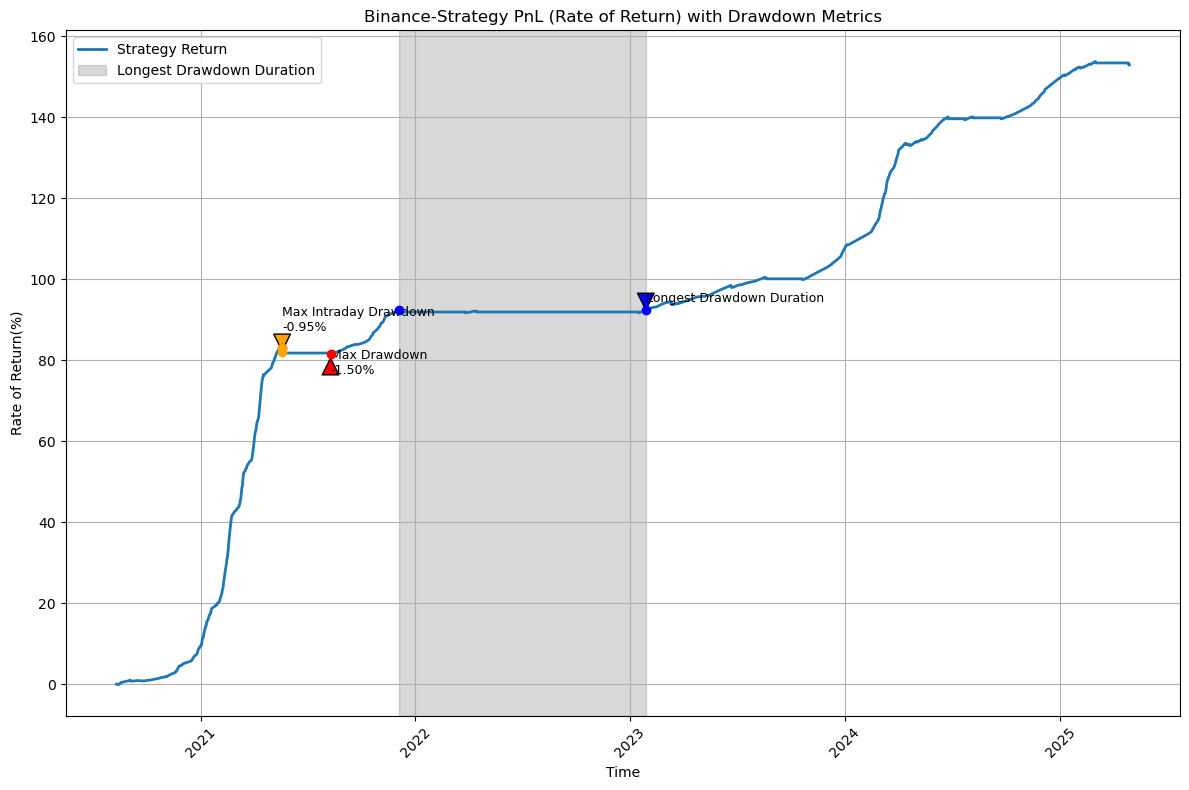

In [29]:
plt.figure(figsize=(12,8))
plt.plot(df["Timestamp"], df["Return"]*100, label="Strategy Return", lw=2)
plt.xlabel("Time")
plt.ylabel("Rate of Return(%)")
plt.title("Binance-Strategy PnL (Rate of Return) with Drawdown Metrics")
plt.xticks(rotation=45)

# Mark maximum drawdown (red)
plt.scatter([peak_time, trough_time], [peak_return*100, trough_return*100], color="red", zorder=5)
plt.annotate("Max Drawdown\n{:.2%}".format(max_drawdown_value),
             xy=(trough_time, trough_return*100-1),
             xytext=(trough_time, trough_return*100-5),
             arrowprops=dict(facecolor='red', shrink=0.05),
             fontsize=9)

# Mark maximum intraday drawdown (orange)
if intraday_peak_idx is not None:
    plt.scatter([intraday_peak_time, intraday_trough_time],
                [intraday_peak_return*100, intraday_trough_return*100],
                color="orange", zorder=5)
    plt.annotate("Max Intraday Drawdown\n{:.2%}".format(intraday_max_dd),
                 xy=(intraday_trough_time, intraday_trough_return*100),
                 xytext=(intraday_trough_time, intraday_trough_return*100 + 5),
                 arrowprops=dict(facecolor='orange', shrink=0.05),
                 fontsize=9)

# Highlight the longest drawdown duration (grey)
plt.axvspan(longest_start, longest_end, color='grey', alpha=0.3, label="Longest Drawdown Duration")

# Mark the endpoints of the longest drawdown (blue)
plt.scatter([longest_start, longest_end],
            [df.loc[longest_start_index, "Return"]*100, df.loc[longest_end_index, "Return"]*100],
            color="blue", zorder=5)
plt.annotate("Longest Drawdown Duration",
             xy=(longest_end, df.loc[longest_end_index, "Return"]*100),
             xytext=(longest_end, df.loc[longest_end_index, "Return"]*100+2),
             arrowprops=dict(facecolor='blue', shrink=0.05),
             fontsize=9)

plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

#### Calculate intraday drawdown for each timestamp (resetting each day)
#### Plot price, MA line and trade points

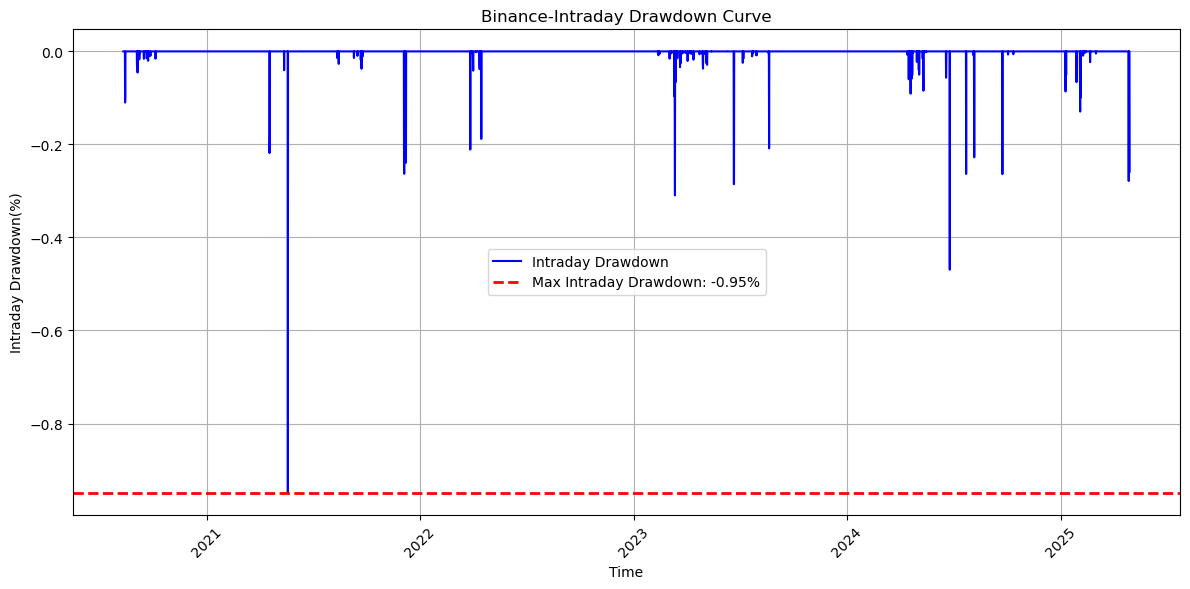

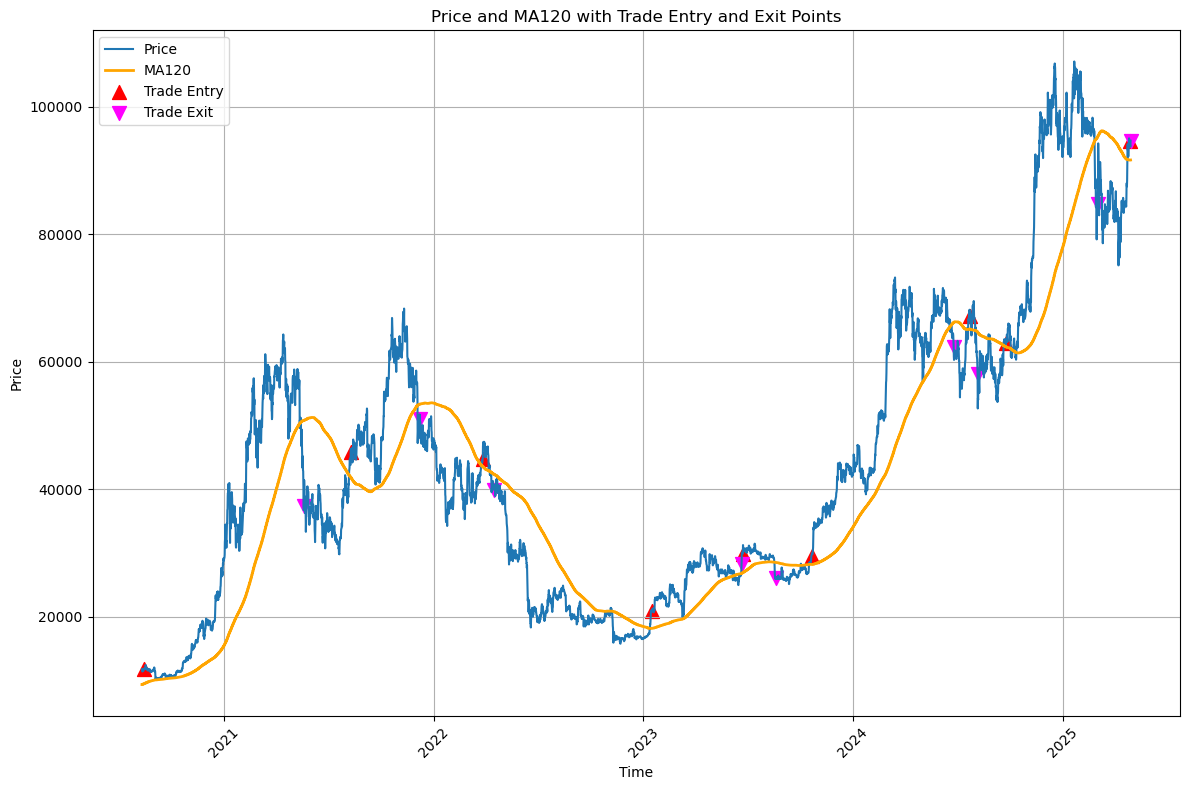

In [30]:
# Calculate intraday drawdown for each timestamp (resetting each day)
df['Intraday_Drawdown'] = df.groupby('Date')['Return'].transform(lambda x: x - x.cummax())

# Plot the intraday drawdown curve
plt.figure(figsize=(12, 6))
plt.plot(df["Timestamp"], df["Intraday_Drawdown"]*100, label="Intraday Drawdown", color='blue')
# Add a horizontal red dashed line at the maximum intraday drawdown level
plt.axhline(y=intraday_max_dd*100, color='red', linestyle='--', linewidth=2, 
            label=f"Max Intraday Drawdown: {intraday_max_dd:.2%}")
plt.xlabel("Time")
plt.ylabel("Intraday Drawdown(%)")
plt.title("Binance-Intraday Drawdown Curve")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

# Plot BTC price, MA120 and trade points
plt.figure(figsize=(12,8))
plt.plot(df["Timestamp"], df["Close_spot"], label="Price", lw=1.5)
plt.plot(df["Timestamp"], df["MA120"], label="MA120", lw=2, color="orange")

# Extract open and close points from the trades list
if trades:
    open_times = [trade["open_time"] for trade in trades]
    entry_prices = [trade["entry_price"] for trade in trades]
    close_times = [trade["close_time"] for trade in trades]
    exit_prices = [trade["exit_price"] for trade in trades]
    
    plt.scatter(open_times, entry_prices, marker="^", color="red", s=100, label="Trade Entry")
    plt.scatter(close_times, exit_prices, marker="v", color="magenta", s=100, label="Trade Exit")

plt.xlabel("Time")
plt.ylabel("Price")
plt.title("Price and MA120 with Trade Entry and Exit Points")
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

#### Funding Rate Over Time (Earned & Not Earned)

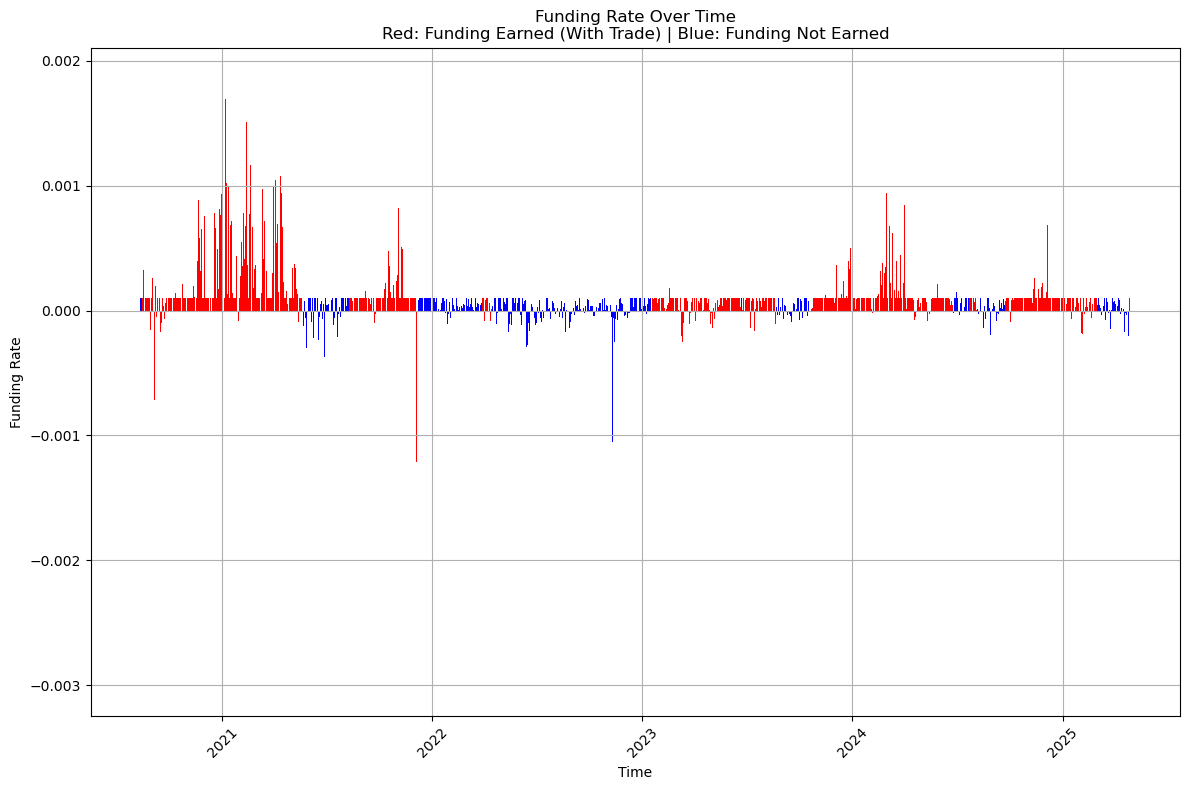

In [31]:
# Create a column to indicate if a trade was open during that period
df["in_trade"] = df["Trade_PnL"].notna()

# Set up the bar colors
bar_colors = df["in_trade"].map({True: "red", False: "blue"})

plt.figure(figsize=(12, 8))
plt.bar(df["Timestamp"], df["Funding Rate"], color=bar_colors, width=0.3)
plt.xlabel("Time")
plt.ylabel("Funding Rate")
plt.title("Funding Rate Over Time\nRed: Funding Earned (With Trade) | Blue: Funding Not Earned")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Calculate daily equity data

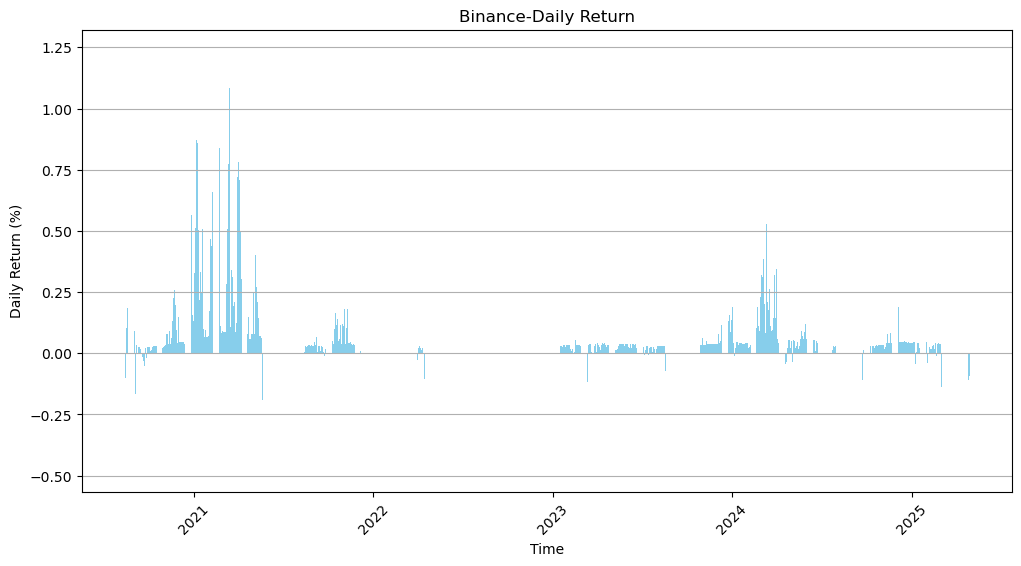

In [32]:
df['Date'] = df['Timestamp'].dt.date

# For each date, take the equity of the last period of the day
daily_equity = df.groupby('Date')['Equity'].last().reset_index()

# Calculate daily return (percentage)
daily_equity['Daily_Return'] = daily_equity['Equity'].pct_change() * 100

plt.figure(figsize=(12, 6))
plt.bar(daily_equity['Date'], daily_equity['Daily_Return'], color='skyblue')
plt.xlabel("Time")
plt.ylabel("Daily Return (%)")
plt.title("Binance-Daily Return")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

#### Analyze funding rate distribution VS MA120

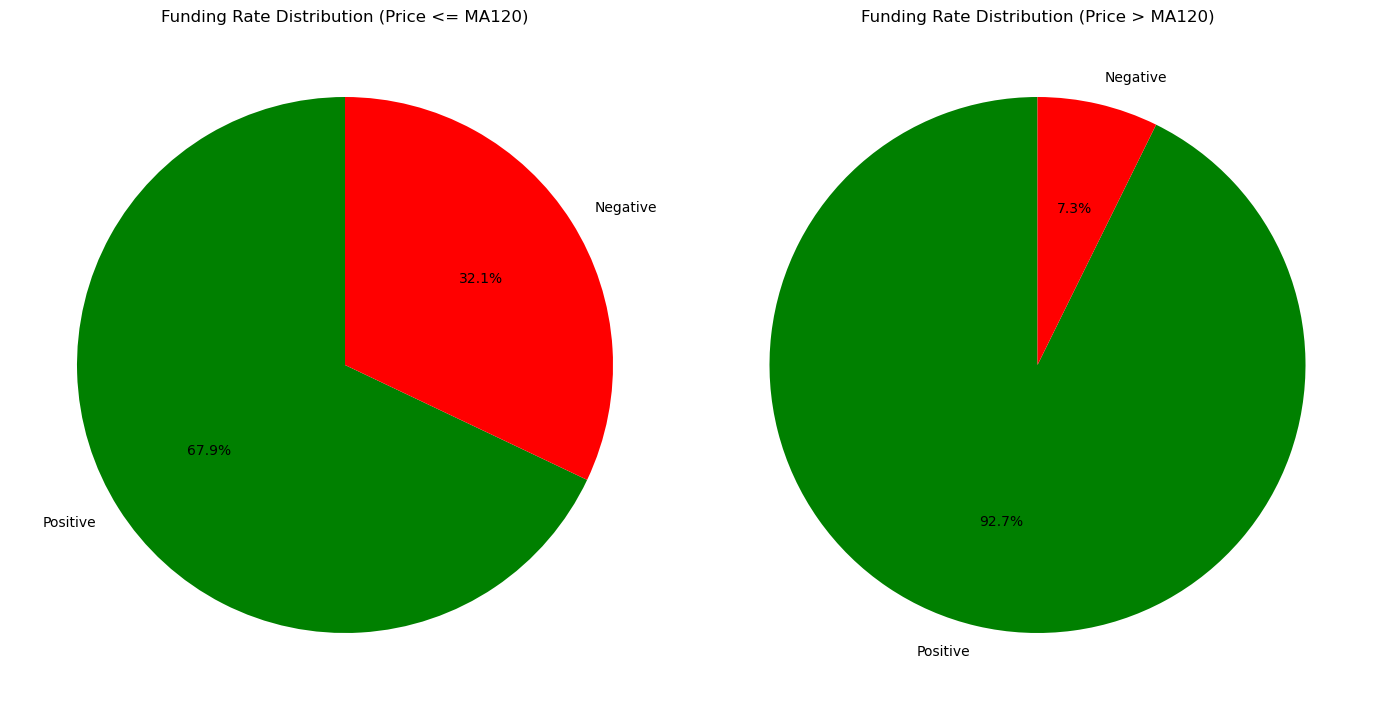

In [33]:
# Analyze funding rate distribution
df_le = df[df["Close_spot"] <= df["MA120"]]
pos_le = df_le[df_le["Funding Rate"] > 0].shape[0]
neg_le = df_le[df_le["Funding Rate"] < 0].shape[0]

df_gt = df[df["Close_spot"] > df["MA120"]]
pos_gt = df_gt[df_gt["Funding Rate"] > 0].shape[0]
neg_gt = df_gt[df_gt["Funding Rate"] < 0].shape[0]

labels = ["Positive", "Negative"]
sizes_le = [pos_le, neg_le]
sizes_gt = [pos_gt, neg_gt]

colors = ["green", "red"]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
ax1.pie(sizes_le, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
ax1.set_title("Funding Rate Distribution (Price <= MA120)")
ax2.pie(sizes_gt, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
ax2.set_title("Funding Rate Distribution (Price > MA120)")

plt.tight_layout()
plt.show()

#### Plot the strategy's cumulative return vs. the BTC buy-and-hold return

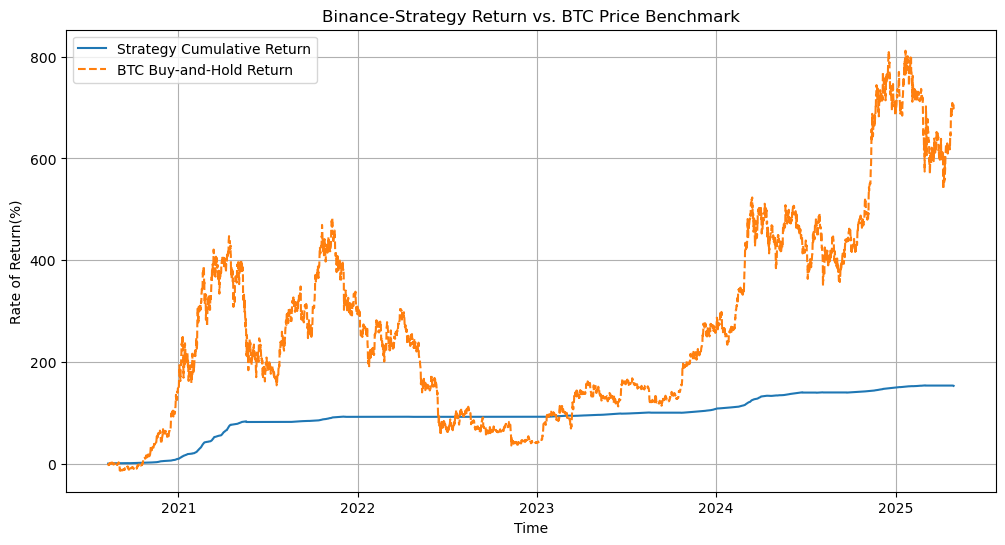

In [34]:
# Calculate the BTC buy-and-hold return using the first period's price as the benchmark
df["BTC_Return"] = df["Close_spot"] / df.iloc[0]["Close_spot"] - 1

plt.figure(figsize=(12, 6))
plt.plot(df["Timestamp"], df["Return"]*100, label="Strategy Cumulative Return")
plt.plot(df["Timestamp"], df["BTC_Return"]*100, label="BTC Buy-and-Hold Return", linestyle='--')
plt.xlabel("Time")
plt.ylabel("Rate of Return(%)")
plt.title("Binance-Strategy Return vs. BTC Price Benchmark")
plt.legend()
plt.grid(True)
plt.show() 